In [1]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/text_summarizati0n')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import pickle
import numpy as np
from nltk.corpus import stopwords
import nltk
import os
import pandas as pd
from attention import AttentionLayer
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from keras.utils import plot_model

from keras.preprocessing.sequence import pad_sequences
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Using TensorFlow backend.


True

prepare dataset for model

In [0]:
csv_file = pd.read_csv('/content/drive/My Drive/Colab Notebooks/text_summarizati0n/dataset/news_summary_more.csv')

In [4]:
csv_file['headlines']

0        upGrad learner switches to career in ML & Al w...
1        Delhi techie wins free food from Swiggy for on...
2        New Zealand end Rohit Sharma-led India's 12-ma...
3        Aegon life iTerm insurance plan helps customer...
4        Have known Hirani for yrs, what if MeToo claim...
                               ...                        
98396    CRPF jawan axed to death by Maoists in Chhatti...
98397    First song from Sonakshi Sinha's 'Noor' titled...
98398           'The Matrix' film to get a reboot: Reports
98399    Snoop Dogg aims gun at clown dressed as Trump ...
98400    Madhesi Morcha withdraws support to Nepalese g...
Name: headlines, Length: 98401, dtype: object

In [5]:
csv_file['text']

0        Saurav Kant, an alumnus of upGrad and IIIT-B's...
1        Kunal Shah's credit card bill payment platform...
2        New Zealand defeated India by 8 wickets in the...
3        With Aegon Life iTerm Insurance plan, customer...
4        Speaking about the sexual harassment allegatio...
                               ...                        
98396    A CRPF jawan was on Tuesday axed to death with...
98397    'Uff Yeh', the first song from the Sonakshi Si...
98398    According to reports, a new version of the 199...
98399    A new music video shows rapper Snoop Dogg aimi...
98400    Madhesi Morcha, an alliance of seven political...
Name: text, Length: 98401, dtype: object

In [6]:
mx1 = 0
mx2 = 0
for i in range(len(csv_file['text'])):
  mx1 = max(mx1,len(csv_file['text'][i]))
  mx2 = max(mx2,len(csv_file['headlines'][i]))

print(mx1,mx2)

frq_text     = []
frq_headline = []

for i in range(len(csv_file['text'])):
  frq_text.append(len(csv_file['text'][i]))
  frq_headline.append(len(csv_file['headlines'][i]))

450 79


##Visualize data

In [0]:
max_input_len = 400
max_output_len = 70

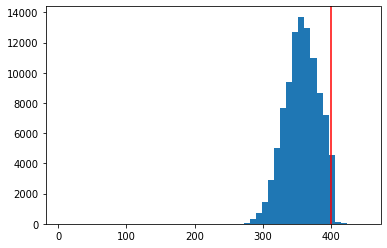

In [8]:
import matplotlib.pyplot as plt
plt.hist(frq_text,bins = 50)
plt.axvline(x=max_input_len,c='red')  ### max sequence length for text input 
plt.show()

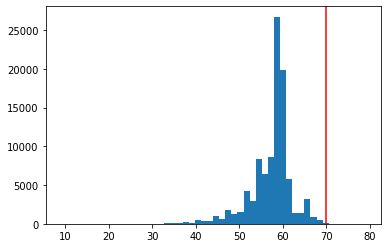

In [9]:
plt.hist(frq_headline,bins = 50)
plt.axvline(x=max_output_len,c='red')  ### max sequence length for output 
plt.show()

## data pre_processing

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
import re

In [0]:
def clean_text(text,add_eos_sos = False):
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-_'()\"#/@;:<>{}`+=~|.!?,]", "", text)
    if add_eos_sos:
      text = '<sos> ' + text + ' <eos>'
    return text

In [12]:
csv_file['text'] = csv_file['text'].apply(clean_text)
csv_file['text']

0        saurav kant an alumnus of upgrad and iiitbs pg...
1        kunal shahs credit card bill payment platform ...
2        new zealand defeated india by 8 wickets in the...
3        with aegon life iterm insurance plan customers...
4        speaking about the sexual harassment allegatio...
                               ...                        
98396    a crpf jawan was on tuesday axed to death with...
98397    uff yeh the first song from the sonakshi sinha...
98398    according to reports a new version of the 1999...
98399    a new music video shows rapper snoop dogg aimi...
98400    madhesi morcha an alliance of seven political ...
Name: text, Length: 98401, dtype: object

In [13]:
csv_file['headlines'] = csv_file['headlines'].apply(clean_text,add_eos_sos = True)
csv_file['headlines']

0        <sos> upgrad learner switches to career in ml ...
1        <sos> delhi techie wins free food from swiggy ...
2        <sos> new zealand end rohit sharmaled indias 1...
3        <sos> aegon life iterm insurance plan helps cu...
4        <sos> have known hirani for yrs what if metoo ...
                               ...                        
98396    <sos> crpf jawan axed to death by maoists in c...
98397    <sos> first song from sonakshi sinhas noor tit...
98398    <sos> the matrix film to get a reboot reports ...
98399    <sos> snoop dogg aims gun at clown dressed as ...
98400    <sos> madhesi morcha withdraws support to nepa...
Name: headlines, Length: 98401, dtype: object

In [0]:
def text_tokenize(text):
  tokens = []
  for line in text:
    tokens.append(text_to_word_sequence(line, lower=True, split=' '))
  return tokens

In [0]:
input_tokens  = text_tokenize(csv_file['text'])
output_tokens  = text_tokenize(csv_file['headlines'])

In [16]:
print(csv_file['text'][0])
print(input_tokens[0])
print('\n\n',csv_file['headlines'][0])
print(output_tokens[0])

saurav kant an alumnus of upgrad and iiitbs pg program in machine learning and artificial intelligence was a sr systems engineer at infosys with almost 5 years of work experience the program and upgrads 360degree career support helped him transition to a data scientist at tech mahindra with 90% salary hike upgrads online power learning has powered 3 lakh careers
['saurav', 'kant', 'an', 'alumnus', 'of', 'upgrad', 'and', 'iiitbs', 'pg', 'program', 'in', 'machine', 'learning', 'and', 'artificial', 'intelligence', 'was', 'a', 'sr', 'systems', 'engineer', 'at', 'infosys', 'with', 'almost', '5', 'years', 'of', 'work', 'experience', 'the', 'program', 'and', 'upgrads', '360degree', 'career', 'support', 'helped', 'him', 'transition', 'to', 'a', 'data', 'scientist', 'at', 'tech', 'mahindra', 'with', '90', 'salary', 'hike', 'upgrads', 'online', 'power', 'learning', 'has', 'powered', '3', 'lakh', 'careers']


 <sos> upgrad learner switches to career in ml & al with 90% salary hike <eos>
['sos', '

## Vocab & embedding matrix

In [0]:
VOCAB_SIZE = 7000

In [0]:
def vocab_creater(text_lists, VOCAB_SIZE):
  tokenizer = Tokenizer(num_words=VOCAB_SIZE)
  tokenizer.fit_on_texts(text_lists)
  dictionary = tokenizer.word_index
  word2idx = {}
  idx2word = {}
  for k, v in dictionary.items():
      if v < VOCAB_SIZE:
          word2idx[k] = v-1
          idx2word[v-1] = k
      if v >= VOCAB_SIZE:
          break
  return word2idx, idx2word

In [0]:
#### create word_index and dump
 
#word2idx, idx2word = vocab_creater(csv_file['text']+csv_file['headlines'],VOCAB_SIZE)
#word_index = {}
#word_index['word2idx'] = word2idx
#word_index['idx2word'] = idx2word
#pickle.dump(word_index, open('word_idx.pkl','wb'))

In [20]:
#load word_index

word_index = pickle.load(open('word_idx.pkl','rb'))
print(word_index.keys())
idx2word = word_index['idx2word']
word2idx = word_index['word2idx']
del word_index
print(word2idx)
print(idx2word)

dict_keys(['word2idx', 'idx2word'])
{'the': 0, 'to': 1, 'in': 2, 'a': 3, 'of': 4, 'and': 5, 'sos': 6, 'eos': 7, 'on': 8, 'for': 9, 'has': 10, 'said': 11, 'that': 12, 'was': 13, 'is': 14, 'by': 15, 'with': 16, 'he': 17, 'after': 18, 'his': 19, 'from': 20, 'as': 21, 'it': 22, 'at': 23, 'will': 24, 'not': 25, 'be': 26, 'an': 27, 'have': 28, 'who': 29, 'had': 30, 'over': 31, 'i': 32, 'her': 33, 'india': 34, 'which': 35, 'been': 36, 'added': 37, 'us': 38, 'were': 39, 'its': 40, 'are': 41, 'this': 42, 'she': 43, 'also': 44, 'their': 45, 'against': 46, 'while': 47, 'police': 48, 'first': 49, 'indian': 50, 'people': 51, 'about': 52, 'crore': 53, 'they': 54, 'government': 55, 'minister': 56, 'film': 57, 'two': 58, 'him': 59, 'up': 60, 'president': 61, 'years': 62, 'new': 63, 'during': 64, 'out': 65, 'man': 66, 'court': 67, 'one': 68, 'would': 69, 'further': 70, 'when': 71, 'year': 72, 'delhi': 73, 'being': 74, 'we': 75, 'pm': 76, 'reports': 77, 'world': 78, 'can': 79, 'reportedly': 80, 'all': 8

In [0]:
GLOVE_PATH = '/content/drive/My Drive/Colab Notebooks/glove.42B.300d.txt'
GLOVE_VECTOR_LENGHT = 300


def read_glove_vectors(path, lenght):
    embeddings = {}
    with open(path) as glove_f:
        for line in glove_f:
            chunks = line.split()
            assert len(chunks) == lenght + 1
            embeddings[chunks[0]] = np.array(chunks[1:], dtype='float32')
    return embeddings


###############################################################################################
#
#GLOVE_INDEX = read_glove_vectors(GLOVE_PATH, GLOVE_VECTOR_LENGHT)
## dump GLOVE_INDEX
#pickle.dump(GLOVE_INDEX, open('/content/drive/My Drive/Colab Notebooks/GLOVE_INDEX.pkl','wb'))
#
################################################################################################

In [0]:
#load glove_index
#GLOVE_INDEX = pickle.load(open('/content/drive/My Drive/Colab Notebooks/GLOVE_INDEX.pkl','rb'))

In [0]:
def embedding_matrix_creater(word_index,embedding_dimention = 300):
  embedding_matrix = np.zeros((len(word_index) + 1, embedding_dimention))
  for i, word in word_index.items():
      embedding_vector = GLOVE_INDEX.get(word)
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector
  return embedding_matrix
  
#embedding_matrix = embedding_matrix_creater(idx2word)
#pickle.dump(embedding_matrix,open('embedding_matrix.pkl','wb'))

In [0]:
embedding_matrix = pickle.load(open('embedding_matrix.pkl','rb'))

In [0]:
def token2seq(text):
  seq = []
  for line in text:
    temp = []
    for word in line:
      if word in word2idx.keys():
        temp.append(word2idx[word])
    seq.append(temp)
  return seq

In [0]:
input_seq = token2seq(input_tokens)
output_seq = token2seq(output_tokens)

In [27]:
print(input_seq[:5])
print(output_seq[:5])

[[27, 4, 5, 1995, 2, 1922, 2552, 5, 1658, 884, 13, 3, 1914, 2338, 23, 1216, 16, 1033, 408, 62, 4, 222, 1588, 0, 1995, 5, 897, 442, 1043, 59, 6082, 1, 3, 217, 3489, 23, 1765, 1879, 16, 1614, 1463, 1933, 296, 418, 2552, 10, 4552, 259, 99, 3748], [4867, 5218, 1512, 1119, 525, 1977, 634, 755, 153, 3, 2510, 1, 220, 520, 407, 20, 6211, 9, 68, 72, 3, 73, 4885, 42, 2860, 18, 3080, 1643, 4611, 153, 149, 68, 3971, 221, 2994, 4, 525, 652, 35, 79, 26, 166, 1, 5578, 20, 3841, 94, 5, 109], [63, 1146, 1015, 34, 15, 658, 824, 2, 0, 898, 364, 23, 5164, 8, 155, 1, 220, 45, 49, 170, 4, 0, 364, 247, 34, 383, 27, 212, 170, 157, 846, 3662, 6083, 18, 309, 1676, 1403, 252, 1, 502, 192, 0, 170, 2195, 34, 611, 81, 65, 9, 5802, 45, 3339, 3164, 496, 2, 364, 188, 627], [16, 232, 1915, 765, 869, 79, 4373, 359, 2840, 8, 391, 652, 5, 1399, 60, 1, 8, 2732, 0, 765, 2328, 232, 1058, 60, 1, 0, 617, 4, 326, 62, 44, 869, 28, 3734, 1, 46, 2595, 5, 4412, 211, 2817, 16, 3, 232, 1058, 60, 1, 0, 617, 4, 1698, 62], [511, 52, 0, 

In [0]:
## padding
input_seq = pad_sequences(input_seq, maxlen = max_input_len, dtype='int32', padding='post', truncating='post')
output_seq = pad_sequences(output_seq, maxlen = max_output_len, dtype='int32', padding='post', truncating='post')


# ***Model***



In [0]:
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, CuDNNLSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional,Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import plot_model

# Model

In [0]:
from keras import backend as K 
K.clear_session() 

EMBEDDING_DIM = 300

# Encoder 
encoder_inputs = Input(shape=(max_input_len,))  ### input (none,max_input_len)

## embedding
enc_emb_layer = Embedding(input_dim = VOCAB_SIZE, output_dim = EMBEDDING_DIM, 
                      input_length = max_input_len, weights = [embedding_matrix],trainable = False)

enc_emb = enc_emb_layer(encoder_inputs)




#LSTM 1 
encoder_lstm1 = Bidirectional(CuDNNLSTM(EMBEDDING_DIM,return_sequences=True,return_state=True))
encoder_output1, _,_,_,_ = encoder_lstm1(enc_emb) 


#LSTM 2 
encoder_lstm2 =   Bidirectional(CuDNNLSTM(EMBEDDING_DIM, return_state=True, return_sequences=True))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm2(encoder_output1) 
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
#encoder_states = [state_h, state_c]



# Set up the decoder. 
decoder_inputs = Input(shape=(None,))  ## input(None,)

### embedding

dec_emb_layer = Embedding(input_dim = VOCAB_SIZE, output_dim = EMBEDDING_DIM, 
                      input_length = max_output_len, weights = [embedding_matrix],trainable = False)


dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = CuDNNLSTM(EMBEDDING_DIM*2, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(VOCAB_SIZE, activation='softmax'))
decoder_dense_outputs = decoder_dense(decoder_concat_input) 





model = Model(inputs = [encoder_inputs, decoder_inputs], outputs = decoder_dense_outputs)

In [97]:
model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy') 
model.load_weights('model_weights2.h5')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 400, 300)     2100000     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 400, 600), ( 1444800     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [0]:
## load history

if os.path.exists('history2.pkl'):
  history = pickle.load(open('history2.pkl','rb'))
else:
  history = {}
  history['loss'] = []
  history['val_loss'] = []
  #pickle.dump(history2,open('history2.pkl','wb'))

In [0]:
epochs = 5
val_loss_prev = history['val_loss'][-1]
for i in range(epochs):
  #train model
  epoch_history = model.fit([input_seq,output_seq[:,:-1]], output_seq.reshape(output_seq.shape[0],output_seq.shape[1], 1)[:,1:] ,
                      epochs=1,batch_size=100,validation_split = 0.05)
  
  ### save model weight on every epochs
  model.save_weights('model_weights2.h5')   

  if val_loss_prev > epoch_history.history['val_loss'][-1]:
    model.save_weights('best_model_weight2.h5')
    val_loss_prev = epoch_history.history['val_loss'][-1]

  history['loss'].append(epoch_history.history['loss'])
  history['val_loss'].append(epoch_history.history['val_loss'])

  #save model history
  pickle.dump(history,open('history2.pkl','wb'))

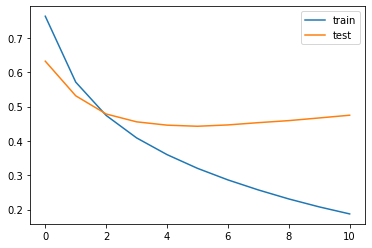

In [100]:
import matplotlib.pyplot as plt
plt.plot(history['loss'], label='train') 
plt.plot(history['val_loss'], label='test') 
plt.legend()
plt.show()

# Decode Seq

In [0]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])




# decoder inference


decoder_state_input_h = Input(shape=(600,))
decoder_state_input_c = Input(shape=(600,))
decoder_hidden_state_input = Input(shape=(max_input_len,600))


dec_emb2= dec_emb_layer(decoder_inputs)


decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])


decoder_outputs2 = decoder_dense(decoder_inf_concat)




# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],[decoder_outputs2] + [state_h2, state_c2])


In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = word2idx['sos']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = idx2word[sampled_token_index]

        if(sampled_token!='sos'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'eos' or len(decoded_sentence.split()) >= (max_input_len-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [0]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=word2idx['sos']) and i!=word2idx['eos']):
        newString=newString+idx2word[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+idx2word[i]+' '
    return newString

In [134]:
for i in range(0,10):
  print("Text : ",seq2text(input_seq[i]))
  print("Original summary :",seq2summary(output_seq[i]))
  print("Predicted summary :",decode_sequence(input_seq[i].reshape(1,max_input_len)),'\n\n')

Text :  an of and program in machine learning and artificial intelligence was a systems engineer at infosys with almost 5 years of work experience program and career support helped him transition to a data scientist at tech mahindra with 90 salary hike online power learning has powered 3 lakh careers 
Original summary : to career in al with 90 salary hike 
Predicted summary :  with 90 salary hike for 5 years eos 


Text :  kunal shahs credit card bill payment platform gave users a chance to win free food from swiggy for one year a delhi bagged this reward after spending 2000 coins users get one coin per rupee of bill paid which can be used to avail from brands like and more 
Original summary : delhi wins free food from swiggy for one year on 
Predicted summary :  delhi wins free food from swiggy for one year gets its eos 


Text :  new zealand defeated india by 8 wickets in fourth odi at hamilton on thursday to win their first match of odi series india lost an international match under

# predict summary

In [0]:
def predict_summary():
  text = input('enter text')
  print('input text:',text)
  clean_text_ = clean_text(text)
  text_input_tokens = text_to_word_sequence(clean_text_, lower=True, split=' ')
  input__seq = []
  for word in text_input_tokens:
    if word in word2idx.keys():
      input__seq.append(word2idx[word])
  input__seq = pad_sequences([input__seq], maxlen = max_input_len, dtype='int32', padding='post', truncating='post')
  print("Predicted summary:",decode_sequence(input__seq.reshape(1,max_input_len)))

In [0]:
predict_summary()